# **TASK 1:** CycleGAN

**Project Setup Guide**

1. Unzipping and Uploading the Project

  - Unzip the `Coursework_chatwipa.zip` file.
  - Upload the extracted folder to your Google Drive, maintaining the following structure:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |  |- model_checkpoints
|  |  |  |- 10 epochs
|  |  |  |- 25 epochs
|  |  |  |- 30 epochs
|  |  |- TASK1.ipynb
|  |  
|  |- TASK 2
|  |- TASK 3
```

2. Uploading Additional Data

    - Place the dataset zip files (`faces.zip` and `cat_and_dog-1.zip`) into the `TASK 1` folder.
    - The final folder structure should be:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |  |- model_checkpoints
|  |  |  |- 10 epochs
|  |  |  |- 25 epochs
|  |  |  |- 30 epochs
|  |  |- TASK1.ipynb
|  |  |- faces.zip
|  |  |- cat_and_dog-1.zip
|  |  
|  |- TASK 2
|  |- TASK 3
```

3. Running the Demonstration

  - Navigate to the **Demonstration** section of the notebook to test the process before proceeding further.

## 1. Load dataset

In [ ]:
# Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_zip_face = "/content/drive/MyDrive/Coursework_chatwipa/TASK 1/faces.zip"
dataset_zip_cat_dog = "/content/drive/MyDrive/Coursework_chatwipa/TASK 1/cat_and_dog-1.zip"

Import library

In [ ]:
import random
import shutil
import os
import cv2
import zipfile
import glob
import numpy as np
import keras
from keras import layers, ops
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

### 1.1 Unzip dataset


Unzip data and store into disk

In [ ]:
# Create human folder
folder = "/content/face_img/"
os.makedirs(folder, exist_ok=True)

# Unzip dataset (faces.zip)
with zipfile.ZipFile(dataset_zip_face, 'r') as zip_ref:
    zip_ref.extractall("/content/face_img/")

# Create cat and dog folder
folder = "/content/cat_and_dog/"
os.makedirs(folder, exist_ok=True)

# Unzip dataset (cat_and_dog-1.zip)
with zipfile.ZipFile(dataset_zip_cat_dog, 'r') as zip_ref:
    zip_ref.extractall("/content/")

dataset_zip = "/content/cat_face.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/cat_and_dog/")

dataset_zip = "/content/dog faces.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/cat_and_dog/")

Read all image path files and store in list

In [ ]:
def load_images(path):
    images_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                images_list.append(img_path)
    return images_list

# Store all images path in list
human_images_path = load_images("/content/face_img")
print("Total number of human images: ", len(human_images_path))
cat_dog_images_path = load_images("/content/cat_and_dog/")
print("Total number of cat and dog images: ", len(cat_dog_images_path))

Total number of human images:  225786
Total number of cat and dog images:  48863


### 1.2 Prepare dataset

- Create a folder structure to match TensorFlow's requirements.  

```
      images
      │── train/
      │   │── Human/
      │   │── Pets/
      │── test/
      │   │── Human/
      │   │── Pets/

```

- Randomly select 100 images from human and cat/dog categories for model testing.  
- Undersample human images to match the total number of cat/dog images.

In [ ]:
# --- Create human folder --- #
trainHuman_path = "/content/images/train/Human"
os.makedirs(trainHuman_path, exist_ok=True)

testHuman_path = "/content/images/test/Human"
os.makedirs(testHuman_path, exist_ok=True)

# --- Create cat and dog folder --- #
trainPets_path = "/content/images/train/Pets"
os.makedirs(trainPets_path, exist_ok=True)

testPets_path = "/content/images/test/Pets"
os.makedirs(testPets_path, exist_ok=True)

Cat/Dog dataset

In [ ]:
# Randomly select 100 cat/dog images for the test set
cat_dog_test_images = random.sample(cat_dog_images_path, 100)
for image_path in cat_dog_test_images:
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/test/Pets", base_name)
    shutil.copy(image_path, dest_path)

# Copy the remaining cat/dog images to the train set
for image_path in set(cat_dog_images_path) - set(cat_dog_test_images):
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/train/Pets", base_name)
    shutil.copy(image_path, dest_path)

In [ ]:
path = "/content/images/train/Pets"
n_train_pet = len(load_images(path))
print("Total number of train images: ", n_train_pet)

path = "/content/images/test/Pets"
n_test_pet = len(load_images(path))
print("Total number of test images: ", n_test_pet)

Total number of train images:  30586
Total number of train images:  86


Human dataset

In [ ]:
# Randomly select human images to match the total number of pets dataset
human_images_path_select = random.sample(human_images_path, n_train_pet + n_test_pet)

# Randomly select 100 human images for the test set
human_test_images = random.sample(human_images_path_select, 100)
for image_path in human_test_images:
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/test/Human", base_name)
    shutil.copy(image_path, dest_path)

# Move the remaining human images to the train set
for image_path in set(human_images_path_select) - set(human_test_images):
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/train/Human", base_name)
    shutil.copy(image_path, dest_path)

In [ ]:
path = "/content/images/train/Pets"
n_train_pet = len(load_images(path))
print("Total number of train images: ", n_train_pet)

path = "/content/images/test/Pets"
n_test_pet = len(load_images(path))
print("Total number of test images: ", n_test_pet)

Total number of train images:  30586
Total number of train images:  86


## 2. Create dataset

Load the dataset using TensorFlow to ensure the format aligns with CycleGAN requirements

In [ ]:
# Remove the 'image/filename' column and retain only 'image' and 'label'.
def preprocess_data(example):
    return example['image'], example['label']

# Load the entire dataset from the folder structure
builder = tfds.ImageFolder('/content/images/')
dataset = builder.as_dataset(split='train', shuffle_files=True)
test_dataset = builder.as_dataset(split='test', shuffle_files=True)

# Separate training datasets
trainHuman = dataset.filter(lambda x: x['label'] == 0).map(preprocess_data).prefetch(tf.data.AUTOTUNE)
trainPets = dataset.filter(lambda x: x['label'] == 1).map(preprocess_data).prefetch(tf.data.AUTOTUNE)

# Separate testing datasets
testHuman = test_dataset.filter(lambda x: x['label'] == 0).map(preprocess_data).prefetch(tf.data.AUTOTUNE)
testPets = test_dataset.filter(lambda x: x['label'] == 1).map(preprocess_data).prefetch(tf.data.AUTOTUNE)

## 3. Pre-processing
- Normalize images into the range of [-1, 1].
- Resize images to 128x128 pixels.
- Randomly flip the training images for data augmentation.

In [ ]:
autotune = tf.data.AUTOTUNE
os.environ["KERAS_BACKEND"] = "tensorflow"

# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)

# Funtion for image normalization
def normalize_img(img):
    img = ops.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

# Funtion for preprocessing train image
def preprocess_train_image(img, label):
    orig_img_size = (128, 128)
    img = tf.image.random_flip_left_right(img)
    img = ops.image.resize(img, [*orig_img_size])
    img = normalize_img(img)
    return img

# Funtion for preprocessing test image
def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = ops.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

# Parameter setting
buffer_size = 256
batch_size = 16

# Apply the preprocessing operations to the training data
train_human = (
    trainHuman.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_pets = (
    trainPets.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_human = (
    testHuman.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

test_pets = (
    testPets.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

Check the size of trian and test images

In [ ]:
count = sum(1 for _ in train_human)
print(f"Number of batches in train_human: {count}")

total_images = count * batch_size
print(f"Total number of images in train_human: {total_images}")

Number of batches in train_human: 1911
Total number of images in train_human: 30576


In [ ]:
count = sum(1 for _ in train_pets)
print(f"Number of batches in train_pets: {count}")

total_images = count * batch_size
print(f"Total number of images in train_pets: {total_images}")

Number of batches in train_pets: 1912
Total number of images in train_pets: 30592


Image visualization

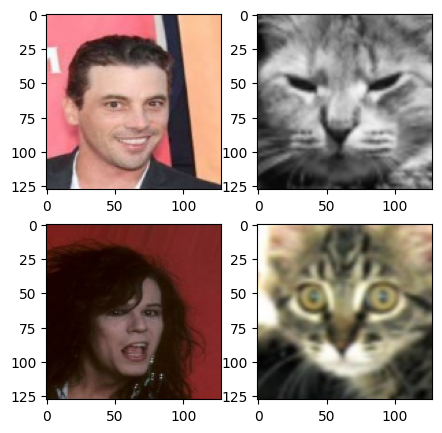

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(5, 5))
for i, samples in enumerate(zip(train_human.take(2), train_pets.take(2))):
    # Rescale image from [-1,1] to [0, 255]
    horse = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    zebra = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    ax[i, 0].imshow(horse)
    ax[i, 1].imshow(zebra)
plt.show()

## 4. CycleGAN Model

Reference: https://keras.io/examples/generative/cyclegan/

### 4.1 Building blocks

In [6]:
# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)

# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)


class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super().__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [[0, 0], [padding_height, padding_height], [padding_width, padding_width], [0, 0],]
        return ops.pad(input_tensor, padding_tensor, mode="REFLECT")

def residual_block(x, activation, kernel_initializer=kernel_init, kernel_size=(3, 3),
                   strides=(1, 1), padding="valid", gamma_initializer=gamma_init, use_bias=False,):

    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding, use_bias=use_bias,)(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(dim, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding, use_bias=use_bias,)(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])

    return x

def downsample(x, filters, activation, kernel_initializer=kernel_init, kernel_size=(3, 3),
               strides=(2, 2), padding="same", gamma_initializer=gamma_init, use_bias=False,):

    x = layers.Conv2D(filters, kernel_size, strides=strides, kernel_initializer=kernel_initializer,
                      padding=padding, use_bias=use_bias,)(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)

    return x

def upsample(x, filters, activation, kernel_size=(3, 3), strides=(2, 2), padding="same",
             kernel_initializer=kernel_init, gamma_initializer=gamma_init, use_bias=False,):

    x = layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding,
                               kernel_initializer=kernel_initializer, use_bias=use_bias,)(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)

    return x


### 4.2 Generators

In [7]:
def get_resnet_generator(filters=64, num_downsampling_blocks=2, num_residual_blocks=9,
                         num_upsample_blocks=2, gamma_initializer=gamma_init, name=None,):

    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(x)
    x = keras.layers.GroupNormalization(groups=1, gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

### 4.3 Discriminator

In [8]:
def get_discriminator(filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None):

    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(filters, (4, 4), strides=(2, 2), padding="same", kernel_initializer=kernel_initializer,)(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(2, 2),)
        else:
            x = downsample(x, filters=num_filters, activation=layers.LeakyReLU(0.2), kernel_size=(4, 4), strides=(1, 1),)

    x = layers.Conv2D(1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer)(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)

    return model

Get the generators and discriminators

In [9]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G")
gen_F = get_resnet_generator(name="generator_F")

# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

### 4.4 Build the CycleGAN model

In [10]:
class CycleGan(keras.Model):
    def __init__(self, generator_G, generator_F, discriminator_X,
                 discriminator_Y, lambda_cycle=10.0, lambda_identity=0.5,):

        super().__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def call(self, inputs):
        return (self.disc_X(inputs), self.disc_Y(inputs),
                self.gen_G(inputs), self.gen_F(inputs),)

    def compile(self, gen_G_optimizer, gen_F_optimizer, disc_X_optimizer,
                disc_Y_optimizer, gen_loss_fn,disc_loss_fn,):

        super().compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Human Face and y is pet (Cats and Dogs)
        real_x, real_y = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # Human to fake pets
            fake_y = self.gen_G(real_x, training=True)

            # Pets to fake Human -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Human to fake Pets to fake Human): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)

            # Cycle (Pets to fake Human to fake Pets) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adversarial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (self.identity_loss_fn(real_y, same_y) * self.lambda_cycle * self.lambda_identity)
            id_loss_F = (self.identity_loss_fn(real_x, same_x) * self.lambda_cycle * self.lambda_identity)

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(zip(grads_G, self.gen_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(zip(grads_F, self.gen_F.trainable_variables))

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(zip(disc_X_grads, self.disc_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(zip(disc_Y_grads, self.disc_Y.trainable_variables))

        return {"G_loss": total_loss_G, "F_loss": total_loss_F, "D_X_loss": disc_X_loss, "D_Y_loss": disc_Y_loss,}

### 4.5 Callback

In [11]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images every 5 epochs"""

    def __init__(self, num_img=2, output_dir="/content/drive/MyDrive/Deep learning model/Task1/images/"):
        self.num_img = num_img
        self.output_dir = output_dir
        os.makedirs(self.output_dir, exist_ok=True)  # Ensure directory exists

    def on_epoch_end(self, epoch, logs=None):
        # Only generate and save images every 10 epochs
        if ((epoch+1) % 5 == 0)|(epoch+1==1):
            fig, ax = plt.subplots(self.num_img, 2, figsize=(5, 5))

            # test_images = iter(test_human.take(self.num_img))  # Convert dataset to iterator
            test_images = iter(test_human.take(5))

            for i in range(self.num_img):
                img = next(test_images)  # Get next image from dataset

                # Generate prediction
                prediction = self.model.gen_G(img, training=False)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

                # Prepare the input image
                img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

                # Display images
                ax[i, 0].imshow(img)
                ax[i, 1].imshow(prediction)
                ax[i, 0].set_title("Input image")
                ax[i, 1].set_title("Translated image")
                ax[i, 0].axis("off")
                ax[i, 1].axis("off")

                # Save the generated image
                save_path = os.path.join(self.output_dir, f"generated_img_{i}_epoch_{epoch + 1}.png")
                prediction_img = keras.utils.array_to_img(prediction)
                prediction_img.save(save_path)

            plt.tight_layout()
            plt.show()
            plt.close(fig)

Train the end-to-end model

In [12]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(ops.ones_like(fake), fake)
    return fake_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(ops.ones_like(real), real)
    fake_loss = adv_loss_fn(ops.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

# Create cycle gan model
cycle_gan_model = CycleGan(
    generator_G=gen_G, generator_F=gen_F, discriminator_X=disc_X, discriminator_Y=disc_Y
)

# Before compiling, build the model with a sample input
sample_input_shape = (1,) + input_img_size # Assuming batch_size = 1
cycle_gan_model.build(input_shape=sample_input_shape)

# Compile the model
cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

# Callbacks
plotter = GANMonitor()
checkpoint_filepath = "/content/model_checkpoints/cyclegan_checkpoints.weights.h5"
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True,verbose=1)

## 5. Model training

### 5.1 Train 10 Epochs

Epoch 1/10
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - D_X_loss: 0.1409 - D_Y_loss: 0.1808 - F_loss: 2.8370 - G_loss: 2.3990

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


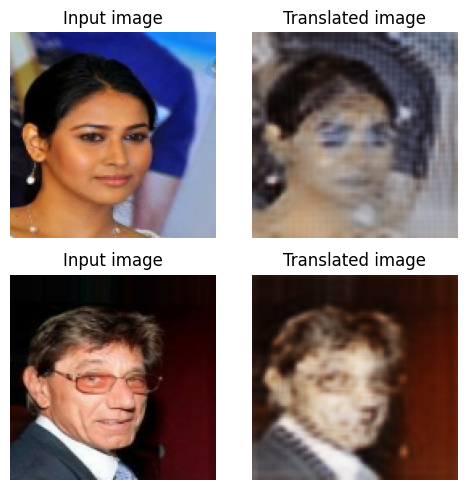


Epoch 1: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 496s 201ms/step - D_X_loss: 0.1409 - D_Y_loss: 0.1807 - F_loss: 2.8366 - G_loss: 2.3988
Epoch 2/10
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1800 - D_Y_loss: 0.2132 - F_loss: 2.2700 - G_loss: 2.0790
Epoch 2: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.1800 - D_Y_loss: 0.2132 - F_loss: 2.2698 - G_loss: 2.0789
Epoch 3/10
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.2119 - D_Y_loss: 0.2227 - F_loss: 1.9507 - G_loss: 1.9281
Epoch 3: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.2119 - D_Y_loss: 0.2227 - F_loss: 1.9509 - G_loss: 1.9284
Epoch 4/10
191

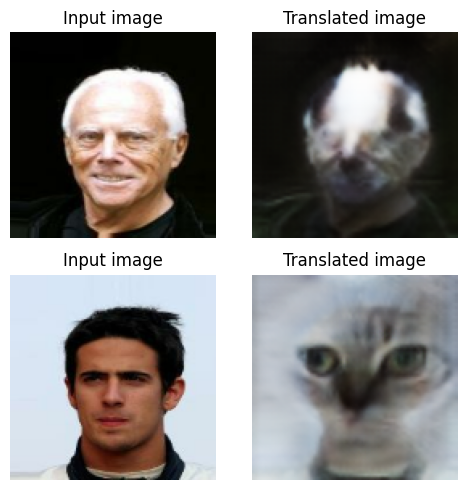


Epoch 5: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.2181 - D_Y_loss: 0.2220 - F_loss: 1.8370 - G_loss: 1.8607
Epoch 6/10
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.2164 - D_Y_loss: 0.2175 - F_loss: 1.8108 - G_loss: 1.8689
Epoch 6: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.2164 - D_Y_loss: 0.2176 - F_loss: 1.8108 - G_loss: 1.8690
Epoch 7/10
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.2140 - D_Y_loss: 0.2157 - F_loss: 1.8081 - G_loss: 1.8829
Epoch 7: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.2140 - D_Y_loss: 0.2158 - F_loss: 1.8082 - G_loss: 1.8829
Epoch 8/10
191

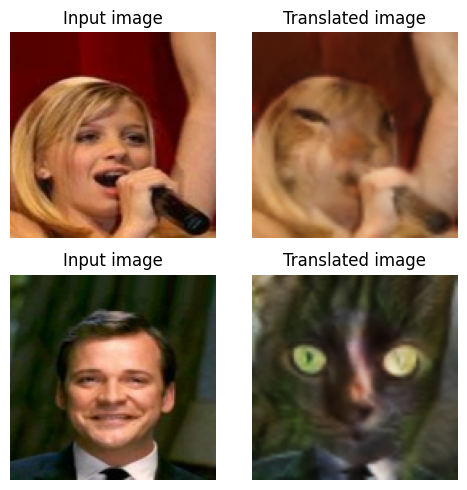


Epoch 10: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.2105 - D_Y_loss: 0.2097 - F_loss: 1.8150 - G_loss: 1.8980


In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 6 minutes on A100 GPU
cycle_gan_model.fit(tf.data.Dataset.zip((train_human, train_pets)), epochs=10,
                    callbacks=[plotter, model_checkpoint_callback], steps_per_epoch = count)

Test the performance of the model.

Weights loaded successfully


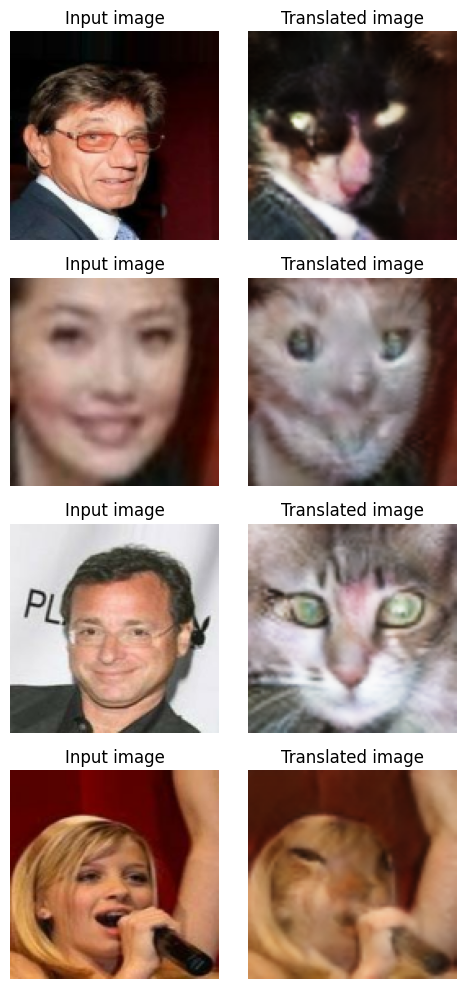

In [ ]:
# Once the weights are loaded, we will take a few samples from the test data and check the model's performance.
# Load the checkpoints
cycle_gan_model.load_weights(checkpoint_filepath)
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(5, 10))
for i, img in enumerate(test_human.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

### 5.2 Train 25 Epochs

Epoch 1/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - D_X_loss: 0.2100 - D_Y_loss: 0.2121 - F_loss: 1.8177 - G_loss: 1.8791

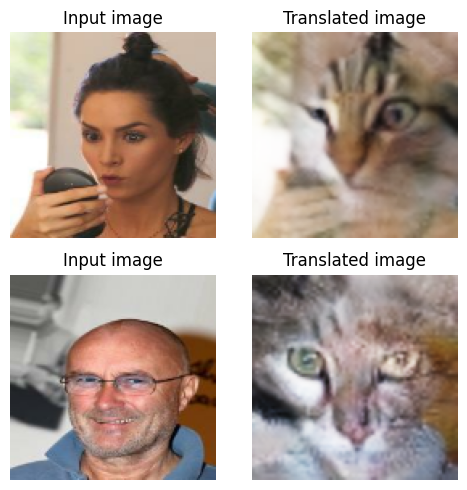


Epoch 1: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 333s 174ms/step - D_X_loss: 0.2100 - D_Y_loss: 0.2120 - F_loss: 1.8179 - G_loss: 1.8791
Epoch 2/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.2071 - D_Y_loss: 0.2098 - F_loss: 1.8389 - G_loss: 1.8993
Epoch 2: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.2071 - D_Y_loss: 0.2098 - F_loss: 1.8388 - G_loss: 1.8994
Epoch 3/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.2052 - D_Y_loss: 0.2085 - F_loss: 1.8564 - G_loss: 1.8957
Epoch 3: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.2053 - D_Y_loss: 0.2085 - F_loss: 1.8564 - G_loss: 1.8957
Epoch 4/25
191

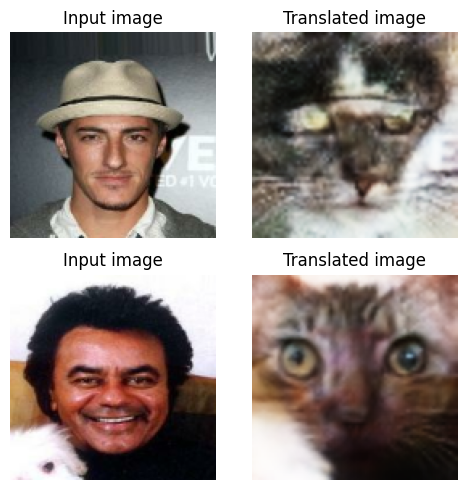


Epoch 5: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.2006 - D_Y_loss: 0.2052 - F_loss: 1.8990 - G_loss: 1.9125
Epoch 6/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1980 - D_Y_loss: 0.2035 - F_loss: 1.8997 - G_loss: 1.9040
Epoch 6: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1981 - D_Y_loss: 0.2035 - F_loss: 1.8998 - G_loss: 1.9041
Epoch 7/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1958 - D_Y_loss: 0.2011 - F_loss: 1.9212 - G_loss: 1.9381
Epoch 7: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1958 - D_Y_loss: 0.2011 - F_loss: 1.9211 - G_loss: 1.9381
Epoch 8/25
191

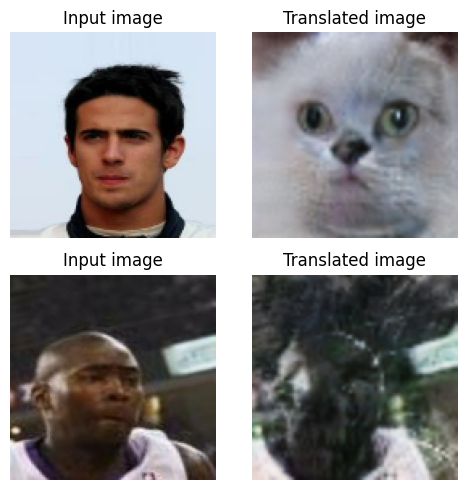


Epoch 10: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1825 - D_Y_loss: 0.1965 - F_loss: 1.9694 - G_loss: 1.9116
Epoch 11/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1806 - D_Y_loss: 0.1942 - F_loss: 1.9899 - G_loss: 1.9181
Epoch 11: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.1806 - D_Y_loss: 0.1942 - F_loss: 1.9900 - G_loss: 1.9182
Epoch 12/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1785 - D_Y_loss: 0.1925 - F_loss: 1.9911 - G_loss: 1.9201
Epoch 12: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.1784 - D_Y_loss: 0.1925 - F_loss: 1.9911 - G_loss: 1.9201
Epoch 13/

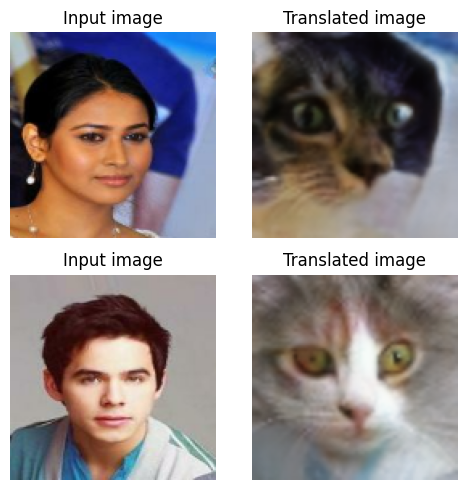


Epoch 15: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1677 - D_Y_loss: 0.1858 - F_loss: 2.0314 - G_loss: 1.9225
Epoch 16/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1651 - D_Y_loss: 0.1836 - F_loss: 2.0549 - G_loss: 1.9150
Epoch 16: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1651 - D_Y_loss: 0.1836 - F_loss: 2.0550 - G_loss: 1.9150
Epoch 17/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1642 - D_Y_loss: 0.1822 - F_loss: 2.0634 - G_loss: 1.9242
Epoch 17: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.1642 - D_Y_loss: 0.1822 - F_loss: 2.0636 - G_loss: 1.9242
Epoch 18/

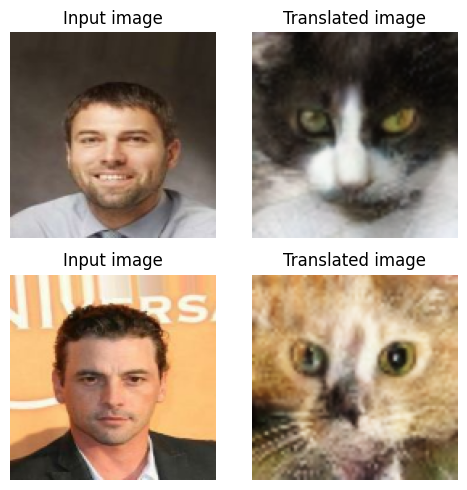


Epoch 20: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1607 - D_Y_loss: 0.1761 - F_loss: 2.0756 - G_loss: 1.9411
Epoch 21/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1587 - D_Y_loss: 0.1739 - F_loss: 2.0839 - G_loss: 1.9414
Epoch 21: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 335s 175ms/step - D_X_loss: 0.1586 - D_Y_loss: 0.1739 - F_loss: 2.0839 - G_loss: 1.9415
Epoch 22/25
1911/1912 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - D_X_loss: 0.1560 - D_Y_loss: 0.1727 - F_loss: 2.1006 - G_loss: 1.9406
Epoch 22: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1560 - D_Y_loss: 0.1727 - F_loss: 2.1006 - G_loss: 1.9405
Epoch 23/

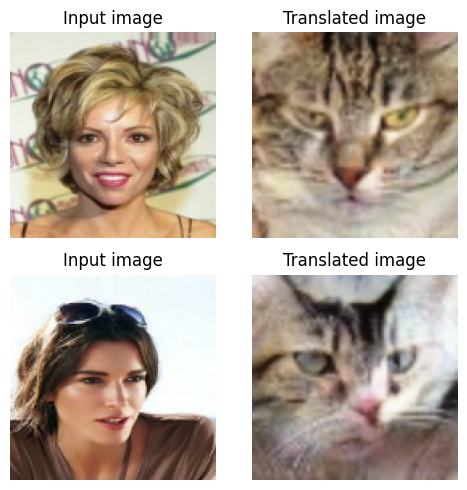


Epoch 25: saving model to /content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/cyclegan_checkpoints.weights.h5
1912/1912 ━━━━━━━━━━━━━━━━━━━━ 336s 176ms/step - D_X_loss: 0.1423 - D_Y_loss: 0.1671 - F_loss: 2.1439 - G_loss: 1.9412


In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 2 minutes on A100 GPU
cycle_gan_model.fit(tf.data.Dataset.zip((train_human, train_pets)), epochs=25,
                    callbacks=[plotter, model_checkpoint_callback],
                    steps_per_epoch=count)

Test the performance of the model.

Weights loaded successfully


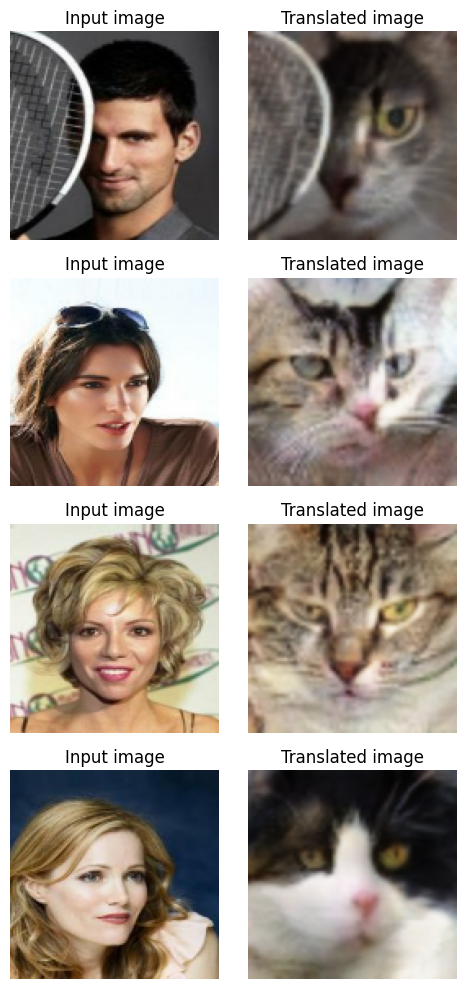

In [ ]:
# Once the weights are loaded, we will take a few samples from the test data and check the model's performance.
# Load the checkpoints
cycle_gan_model.load_weights(checkpoint_filepath)
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(5, 10))
for i, img in enumerate(test_human.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

### 5.3 Train 35 Epochs
Continue from the lastest weight from previous training session

In [ ]:
# Here we will train the model for just one epoch as each epoch takes around
# 17 minutes/epoch on L4 GPU 30 minutes/epoch on T4 GPU
# 6 minutes/epoch on A100 GPU
checkpoint_filepath = "/content/drive/MyDrive/Deep learning model/Task1/model_checkpoints/16_FEB_25/25 Epochs/cyclegan_checkpoints.weights.h5"
cycle_gan_model.load_weights(checkpoint_filepath)
print("Weights loaded successfully")

cycle_gan_model.fit(tf.data.Dataset.zip((train_human, train_pets)), epochs=35,
                    callbacks=[plotter, model_checkpoint_callback],
                    steps_per_epoch=count)

Test the performance of the model.

Weights loaded successfully


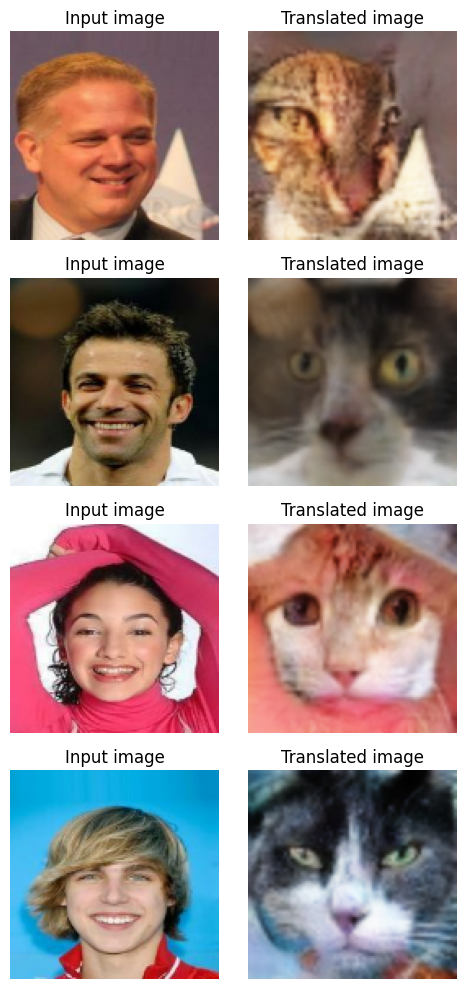

In [ ]:
# Once the weights are loaded, we will take a few samples from the test data and check the model's performance.
# Load the checkpoints
cycle_gan_model.load_weights(checkpoint_filepath)
print("Weights loaded successfully")

_, ax = plt.subplots(4, 2, figsize=(5, 10))
for i, img in enumerate(test_human.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

## 6. Report



**Pre-processing and Data preparation**
1. Data Loading
  - Use `tf.data.Dataset` library which provides efficient image loading, resizing, and normalization while making it compatible with the Keras CycleGAN model.
2. Undersampling Human Face Images
  - Undersampled human face images to match the number of cat/dog images, ensuring a balanced dataset and reducing bias during training.
3. Remove random cropping from original code
  - The original CycleGAN model was designed for horse-to-zebra conversion, where random cropping helps enlarge the images, making training more effective.  
  - However, in our dataset, random cropping may cut off important facial features, leading to poor model performance.  
  - To preserve key facial details, resizing without cropping is a better approach.  
4. Resize images to 128×128
  - Downscaling human images from 256×256 to 128×128 maintains important facial details without excessive loss of information.
  - When upscaling cat/dog images to match the size of human face, it was introducing blurriness and artifacts and increase the training time.
  - Therefore, 128×128 is the opimum image size that balances image quality and training efficiency, ensuring stable CycleGAN transformations.
5. Normalize images
  - Scale the pixel values from [0, 256] to [-1, 1] to stabilize training
6. Image augmentation
  - Apply random horizontal flipping

---

**Results summary**
1. Number of training images affects accuracy
  - To save computational resources, 1,000 images per epoch were used for testing the CycleGAN model. The result showed that the human face was unsuccessfully transformed into a cat or dog, but the color of the image was altered. This indicates that the model was attempting to map the color features from the human face to the cat/dog image, even though the transformation was not perfect.
  - When increasing the number of training images into 30,000 images, the human face was successfully transformed into a cat/dog. This suggests that larger datasets improve the model’s generalization and the ability to learn more complex mappings between the images.
2. Number of epochs affects accuracy
  - Increasing the number of training epochs allows the model to refine its mapping and improve the quality of image transformations.

---
**Potential Problems & Mitigation Strategies**

| **Potential Problem** | **How to Mitigate** |
|----------------------|------------------- |
| Poor performance on human faces with non-uniform backgrounds | Include diverse background variations in the training dataset or apply background augmentation techniques |
| Poor performance on side-profile human faces | Expand the dataset with more side-profile and tilted head images to improve robustness |
| Overfitting due to small dataset | Apply data augmentation or increase dataset size. |
| Unrealistic images | Increase training epochs, use higher-resolution images, and fine-tune hyperparameters. |
| Long training time | Optimize training with transfer learning, early stopping |

## 7. Demonstration

In [1]:
# Mount drive to google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import library

In [5]:
import random
import shutil
import os
import cv2
import zipfile
import glob
import numpy as np
import keras
from keras import layers, ops
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

### 7.1 Convert the images using CycleGAN.

In [13]:
# Define path
image_path = "/content/drive/MyDrive/Coursework_chatwipa/TASK 1/Test_images"

# Please change this path to location of checkpoints
checkpoint_filepath = "/content/drive/MyDrive/Coursework_chatwipa/TASK 1/model_checkpoints/35 Epochs/cyclegan_checkpoints.weights.h5"

# Load images as tf.data.Dataset
test_human = tf.keras.preprocessing.image_dataset_from_directory(image_path, label_mode=None, batch_size=1)

# Normalize images to [-1, 1] for CycleGAN
def normalize_img(img):
    return (img / 127.5) - 1

# Resize and normalize images
def preprocess_test_image(img):
    img = tf.image.resize(img, [128, 128])  # Resize the image to (128, 128)
    img = normalize_img(img)  # Normalize the image
    return img

# Apply the preprocess function to the dataset
test_human = test_human.map(lambda x: preprocess_test_image(x))

# Check the shape of the first batch
for img in test_human.take(6):
    print(f"Shape of image batch: {img.shape}")

Found 3 files.
Shape of image batch: (1, 128, 128, 3)
Shape of image batch: (1, 128, 128, 3)
Shape of image batch: (1, 128, 128, 3)


Note: Please run entire CybleGAN Model section before processing next step

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 144 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Weights loaded successfully


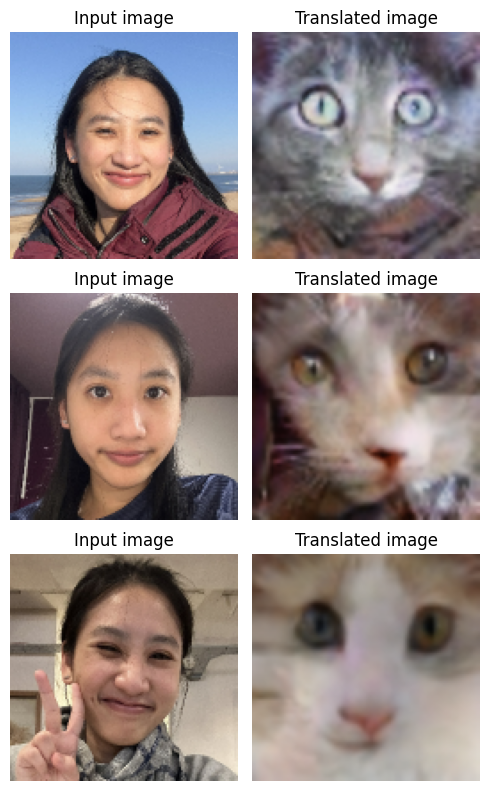

In [14]:
# Once the weights are loaded, we will take a few samples from the test data and check the model's performance.
# Load the checkpoints
cycle_gan_model.load_weights(checkpoint_filepath)
print("Weights loaded successfully")

_, ax = plt.subplots(3, 2, figsize=(5, 8))
for i, img in enumerate(test_human.take(3)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input image")
    ax[i, 0].set_title("Input image")
    ax[i, 1].set_title("Translated image")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.utils.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

### 7.2 Train the CycleGAN for one epoch.

Note: Please run entire CybleGAN Model section before processing next step

In [15]:
dataset_zip_face = "/content/drive/MyDrive/Coursework_chatwipa/TASK 1/faces.zip"
dataset_zip_cat_dog = "/content/drive/MyDrive/Coursework_chatwipa/TASK 1/cat_and_dog-1.zip"

Load and prepare data

In [16]:
# Create human folder
folder = "/content/face_img/"
os.makedirs(folder, exist_ok=True)

# Unzip dataset
with zipfile.ZipFile(dataset_zip_face, 'r') as zip_ref:
    zip_ref.extractall("/content/face_img/")

# Create cat and dog folder
folder = "/content/cat_and_dog/"
os.makedirs(folder, exist_ok=True)

# Unzip dataset
with zipfile.ZipFile(dataset_zip_cat_dog, 'r') as zip_ref:
    zip_ref.extractall("/content/")

dataset_zip = "/content/cat_face.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/cat_and_dog/")

dataset_zip = "/content/dog faces.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/cat_and_dog/")

In [17]:
def load_images(path):
    images_list = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(root, file)
                images_list.append(img_path)
    return images_list

# Store all images path in list
human_images_path = load_images("/content/face_img")
print("Total number of human images: ", len(human_images_path))
cat_dog_images_path = load_images("/content/cat_and_dog/")
print("Total number of cat and dog images: ", len(cat_dog_images_path))

Total number of human images:  225786
Total number of cat and dog images:  48863


In [18]:
# --- Create human folder --- #
trainHuman_path = "/content/images/train/Human"
os.makedirs(trainHuman_path, exist_ok=True)

testHuman_path = "/content/images/test/Human"
os.makedirs(testHuman_path, exist_ok=True)

# --- Create cat and dog folder --- #
trainPets_path = "/content/images/train/Pets"
os.makedirs(trainPets_path, exist_ok=True)

testPets_path = "/content/images/test/Pets"
os.makedirs(testPets_path, exist_ok=True)

Cat/Dog dataset

In [19]:
# Randomly select 100 cat/dog images for the test set
cat_dog_test_images = random.sample(cat_dog_images_path, 100)
for image_path in cat_dog_test_images:
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/test/Pets", base_name)
    shutil.copy(image_path, dest_path)

# Copy the remaining cat/dog images to the train set
for image_path in set(cat_dog_images_path) - set(cat_dog_test_images):
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/train/Pets", base_name)
    shutil.copy(image_path, dest_path)

In [20]:
path = "/content/images/train/Pets"
n_train_pet = len(load_images(path))
print("Total number of train images: ", n_train_pet)

path = "/content/images/test/Pets"
n_test_pet = len(load_images(path))
print("Total number of test images: ", n_test_pet)

Total number of train images:  30590
Total number of test images:  83


Human dataset

In [21]:
# Randomly select human images to match the total number of pets dataset
human_images_path_select = random.sample(human_images_path, n_train_pet + n_test_pet)

# Randomly select 100 human images for the test set
human_test_images = random.sample(human_images_path_select, 100)
for image_path in human_test_images:
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/test/Human", base_name)
    shutil.copy(image_path, dest_path)

# Move the remaining human images to the train set
for image_path in set(human_images_path_select) - set(human_test_images):
    base_name = os.path.basename(image_path)
    dest_path = os.path.join("/content/images/train/Human", base_name)
    shutil.copy(image_path, dest_path)

In [22]:
path = "/content/images/train/Pets"
n_train_pet = len(load_images(path))
print("Total number of train images: ", n_train_pet)

path = "/content/images/test/Pets"
n_test_pet = len(load_images(path))
print("Total number of test images: ", n_test_pet)

Total number of train images:  30590
Total number of test images:  83


In [23]:
# Remove the 'image/filename' column and retain only 'image' and 'label'.
def preprocess_data(example):
    return example['image'], example['label']

# Load the entire dataset from the folder structure
builder = tfds.ImageFolder('/content/images/')
dataset = builder.as_dataset(split='train', shuffle_files=True)
test_dataset = builder.as_dataset(split='test', shuffle_files=True)

# Separate training datasets
trainHuman = dataset.filter(lambda x: x['label'] == 0).map(preprocess_data).prefetch(tf.data.AUTOTUNE)
trainPets = dataset.filter(lambda x: x['label'] == 1).map(preprocess_data).prefetch(tf.data.AUTOTUNE)

# Separate testing datasets
testHuman = test_dataset.filter(lambda x: x['label'] == 0).map(preprocess_data).prefetch(tf.data.AUTOTUNE)
testPets = test_dataset.filter(lambda x: x['label'] == 1).map(preprocess_data).prefetch(tf.data.AUTOTUNE)

In [24]:
autotune = tf.data.AUTOTUNE
os.environ["KERAS_BACKEND"] = "tensorflow"

# Size of the random crops to be used during training.
input_img_size = (128, 128, 3)

# Funtion for image normalization
def normalize_img(img):
    img = ops.cast(img, dtype=tf.float32)
    return (img / 127.5) - 1.0

# Funtion for preprocessing train image
def preprocess_train_image(img, label):
    orig_img_size = (128, 128)
    img = tf.image.random_flip_left_right(img)
    img = ops.image.resize(img, [*orig_img_size])
    img = normalize_img(img)
    return img

# Funtion for preprocessing test image
def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = ops.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

# Parameter setting
buffer_size = 256
batch_size = 1

# Apply the preprocessing operations to the training data
train_human = (
    trainHuman.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)
train_pets = (
    trainPets.map(preprocess_train_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

# Apply the preprocessing operations to the test data
test_human = (
    testHuman.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

test_pets = (
    testPets.map(preprocess_test_image, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size)
    .batch(batch_size)
)

Check the size of trian and test images

In [25]:
count = sum(1 for _ in train_human)
print(f"Number of batches in train_human: {count}")

total_images = count * batch_size
print(f"Total number of images in train_human: {total_images}")

Number of batches in train_human: 30573
Total number of images in train_human: 30573


In [26]:
count = sum(1 for _ in train_pets)
print(f"Number of batches in train_pets: {count}")

total_images = count * batch_size
print(f"Total number of images in train_pets: {total_images}")

Number of batches in train_pets: 30590
Total number of images in train_pets: 30590


Model training

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109s/step - D_X_loss: 0.3801 - D_Y_loss: 0.1520 - F_loss: 2.7696 - G_loss: 2.2875

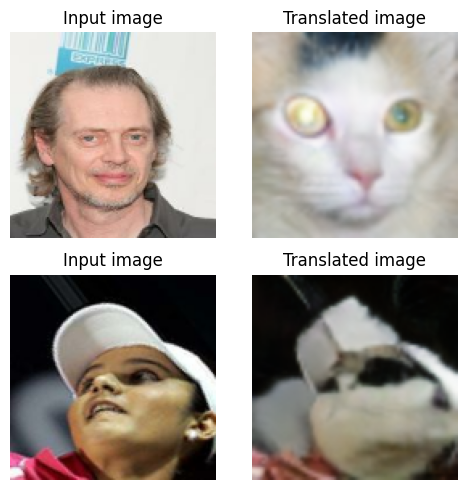

1/1 ━━━━━━━━━━━━━━━━━━━━ 111s 111s/step - D_X_loss: 0.3801 - D_Y_loss: 0.1520 - F_loss: 2.7696 - G_loss: 2.2875


In [27]:
count = sum(1 for _ in train_human)

cycle_gan_model.fit(tf.data.Dataset.zip((train_human, train_pets)), epochs=1,
                    callbacks=[plotter], steps_per_epoch = 1) # Not save the checkpoints model